# Colab Imports

In [ ]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [ ]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy langchain-pinecone pinecone-notebooks

# Settings & Loadings

In [ ]:
import os
import json
import pandas as pd

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")

df_one = pd.read_csv(os.path.join(CSVs, "test_preprocessed_data.csv"))

# Models, Schema & State
- `gpt-4o-mini`
- `text-embedding-3-large`

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
from pydantic import BaseModel
from typing import Annotated, List

class RequestDto(BaseModel):
  title: str
  url: str
  content: str

class EmbeddedRequest(BaseModel):
  query: str

class ResponseDto(BaseModel):
  korean_name: str
  english_name: str
  ticker_code: str

class FlowState(BaseModel):
  request_dto: RequestDto
  response_dto: List[ResponseDto]

# Agents, Nodes & Tools

## Agents

In [ ]:
def embedding_agent(state= FlowState) -> FlowState:
  # query = state.request_dto.title + " " + state.request_dto.content
  # state.embedded_request_kor.query = query
  # state.embedded_request_foreign.query = query
  return state

In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from pydantic import BaseModel
from typing import List
from langchain_openai import OpenAIEmbeddings

pc = Pinecone(api_key=userdata.get('PINECONE-API-KEY'))

def retrieved_vector_parser(given_vectors):
    return [
        ResponseDto(
            korean_name=vector.metadata.get("korean_name", "N/A"),
            english_name=vector.metadata.get("english_name", "N/A"),
            ticker_code=vector.metadata.get("ticker_code", "N/A")
        )
        for vector in given_vectors
    ]

def retriever_agent(state: FlowState):
  text = f"{state.request_dto.title}  {state.request_dto.content}"
  print(text)
  # Vector Store init
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
  kor_retriever = retriever_init("sae-embedded-stocks-kor", embeddings, "kospi-900")
  foriegn_retriever = retriever_init("sae-embedded-stocks-foriegn", embeddings, "nasdaq-1000")

  # Invoke
  kor_result = retrieved_vector_parser(kor_retriever.invoke(text))
  foriegn_result = retrieved_vector_parser(foriegn_retriever.invoke(text))
  state.response_dto.extend(kor_result)
  state.response_dto.extend(foriegn_result)
  return state

def retriever_init(index_name: str, embeddings, namespace):
  index = pc.Index(index_name)
  vector_store = PineconeVectorStore(index=index, embedding=embeddings)
  return vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 2, "score_threshold": 0.5,"namespace": namespace},)


In [ ]:
def kor_retriever_agent(state: FlowState) -> FlowState:
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
  retriever = retriever_init("sae-embedded-stocks-kor", embeddings)
  state.response_dto.results.append("kor_retriever_agent result added")
  return state

def foriegn_retriever_agent(state: FlowState) -> FlowState:
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
  retriever = retriever_init("sae-embedded-stocks-foriegn", embeddings)
  state.response_dto.results.append("foriegn_retriever_agent result added")
  return state

## Tools

## Nodes

In [ ]:
def response_parser(state= FlowState) -> FlowState:
  # print(state.response_dto.results)
  return state

# Flow

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_blueprint = StateGraph(state_schema=FlowState)

# Nodes
graph_blueprint.add_node("embedding_agent", embedding_agent)
graph_blueprint.add_node("retriever_agent", retriever_agent)
# graph_blueprint.add_node("kor_retriever_agent", kor_retriever_agent)
# graph_blueprint.add_node("foriegn_retriever_agent", foriegn_retriever_agent)
graph_blueprint.add_node("response_parser", response_parser)

# Start
graph_blueprint.add_edge(START, "embedding_agent")

# Body
# graph_blueprint.add_edge("embedding_agent", "kor_retriever_agent")
# graph_blueprint.add_edge("embedding_agent", "foriegn_retriever_agent")
# graph_blueprint.add_edge("kor_retriever_agent", "response_parser")
# graph_blueprint.add_edge("foriegn_retriever_agent", "response_parser")

graph_blueprint.add_edge("embedding_agent", "retriever_agent")
graph_blueprint.add_edge("retriever_agent", "response_parser")

# End
graph_blueprint.add_edge("response_parser", END)

retrieving_flow = graph_blueprint.compile()

# Visualization

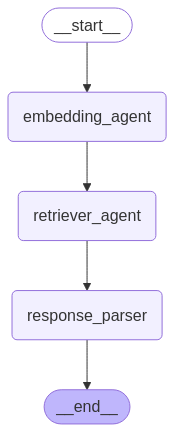

In [ ]:
# Visualize your graph
from IPython.display import Image, display
png = retrieving_flow.get_graph().draw_mermaid_png()
display(Image(png))

# Test

In [ ]:
index = 0
for row in df_one.itertuples(index=False):
    request_dto = RequestDto(title=row.title, url=row.url, content=row.content)
    response_dto = []
    flow_state = FlowState(
        request_dto=request_dto,
        response_dto=response_dto
        )

    result_state = retrieving_flow.invoke(flow_state)
    break
    if index == 10:
        break
    index += 1


NameError: name 'df_one' is not defined